<H2>Part 1: Build a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name

Import data from wikipedia

In [96]:
import pandas as pd

url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
#convert html list to dataframe
df_list = pd.read_html(url)
df_postal_codes=df_list[0]

<h3>Clean data

1) Ignore cells with a borough that is Not assigned.

In [97]:
df_postal_codes=df_postal_codes[df_postal_codes.Borough!="Not assigned"]

In [98]:
df_postal_codes.head()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor


2) If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.
3) More than one neighborhood can exist in one postal code area: these two rows will be combined into one row with the neighborhoods separated with a comma

In [99]:
df_postal_codes1=df_postal_codes.copy()
df_postal_codes1.loc[df_postal_codes1['Neighbourhood']=="Not assigned", "Neighbourhood"]=df_postal_codes1['Borough']


df1=df_postal_codes1.groupby(['Postcode','Borough'], as_index=False).agg(list)
df1.reindex()

#Turn the list into a string, as in the given example
dfn=df1.Neighbourhood.apply(', '.join)
df1.Neighbourhood=dfn
df1.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [100]:
df1.shape

(103, 3)

<h2>Part 2: get the latitude and the longitude coordinates of each neighborhood


Add latitude and longitude columns

In [101]:
df1["latitude"]=""
df1["longitude"]=""

Import data from csv file as geocoder is unreliable

In [102]:
latlong_df = pd.read_csv("http://cocl.us/Geospatial_data/Geospatial_Coordinates.csv")
df1.latitude=latlong_df.Latitude
df1.longitude=latlong_df.Longitude
df1.head()

,Postcode,Borough,Neighbourhood,latitude,longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


<h2>Part 3: Explore and cluster the neighbourhoods
    

In [103]:
#make sure all the libraries are imported
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


Select only neighbourhoods with borough name containing "Toronto"

In [104]:
df_Toronto=df1[df1.Borough.str.contains("Toronto")]
df_Toronto.head()

,Postcode,Borough,Neighbourhood,latitude,longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
42,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [105]:
df_Toronto.shape

(39, 5)

Create map of Toronto just using markers for boroughs with "Toronto"

In [106]:
# create map of Toronto using latitude and longitude values, start from the first neighbourhood
map_toronto = folium.Map(location=[df_Toronto.iloc[10].latitude, df_Toronto.iloc[10].longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_Toronto['latitude'],
                                           df_Toronto['longitude'],
                                           df_Toronto['Borough'],
                                           df_Toronto['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

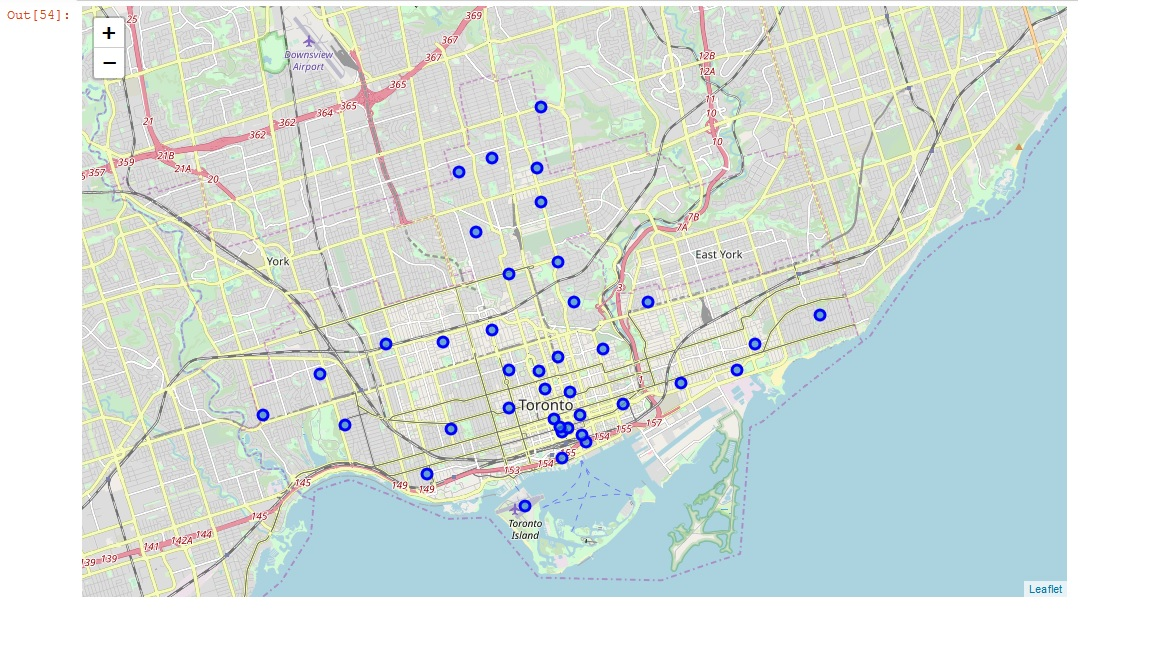

Define FourSquare credentials

In [107]:
CLIENT_ID = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' # Foursquare ID
CLIENT_SECRET = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' # Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT=100

Function to explore neighbourhoods

In [108]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [109]:
toronto_venues = getNearbyVenues(names=df_Toronto['Neighbourhood'],
                                   latitudes=df_Toronto['latitude'],
                                   longitudes=df_Toronto['longitude']
                                  )

The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The Junction Sout

In [110]:
print(toronto_venues.shape)
toronto_venues.head()

(1706, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,"The Danforth West, Riverdale",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant


In [111]:
toronto_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Berczy Park,55,55,55,55,55,55
"Brockton, Exhibition Place, Parkdale Village",24,24,24,24,24,24
Business Reply Mail Processing Centre 969 Eastern,17,17,17,17,17,17
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",16,16,16,16,16,16
"Cabbagetown, St. James Town",42,42,42,42,42,42
Central Bay Street,84,84,84,84,84,84
"Chinatown, Grange Park, Kensington Market",80,80,80,80,80,80
Christie,18,18,18,18,18,18


In [112]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 229 uniques categories.


<h4>ananlyze neighbourhoods
    

In [113]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

Group by mean

In [114]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped.head()

,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.0,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.02,0.0,0.0,0.010000,0.0,0.03,0.0,0.000000,0.000000,0.0,0.000000,0.030000,0.0,0.040000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0000,0.02,0.0,0.01,0.030000,0.000000,0.0,0.01,0.03,0.010000,0.0,0.000000,0.040000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.070000,0.0,0.0,0.0,0.0,0.01,0.000000,0.000000,0.020000,0.000000,0.03,0.0,0.000000,0.0,0.0,0.0,0.01,0.010000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.01,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.01,0.0,0.000000,0.000000,0.0,0.0,0.0,0.010000,0.0,0.000000,0.000000,0.0,0.02,0.0,0.0,0.01,0.0,0.01,0.01,0.000000,0.000000,0.00

Sort venues in descending order

In [115]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create new dataframe with the top 10 venues for each neighborhood.

In [116]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Bar,Steakhouse,Café,Restaurant,Cosmetics Shop,Asian Restaurant,Burger Joint,Breakfast Spot,Thai Restaurant
1,Berczy Park,Coffee Shop,Cocktail Bar,Beer Bar,Seafood Restaurant,Bakery,Farmers Market,Steakhouse,Cheese Shop,Café,Bistro
2,"Brockton, Exhibition Place, Parkdale Village",Breakfast Spot,Café,Nightclub,Coffee Shop,Yoga Studio,Gym,Pet Store,Performing Arts Venue,Office,Italian Restaurant
3,Business Reply Mail Processing Centre 969 Eastern,Skate Park,Recording Studio,Burrito Place,Fast Food Restaurant,Light Rail Station,Farmers Market,Auto Workshop,Restaurant,Spa,Pizza Place
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Service,Airport Terminal,Airport Lounge,Boat or Ferry,Sculpture Garden,Rental Car Location,Coffee Shop,Harbor / Marina,Airport Gate,Airport Food Court


<h4>Cluster neighbourhoods

In [117]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [118]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_Toronto

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged.head() # check the last columns!

,Postcode,Borough,Neighbourhood,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,M4E,East Toronto,The Beaches,43.676357,-79.293031,1,Health Food Store,Pub,Neighborhood,Trail,Discount Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Yoga Studio
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,2,Greek Restaurant,Coffee Shop,Italian Restaurant,Restaurant,Ice Cream Shop,Furniture / Home Store,Frozen Yogurt Shop,Pub,Pizza Place,Liquor Store
42,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,1,Park,Sushi Restaurant,Pet Store,Movie Theater,Pub,Burrito Place,Burger Joint,Liquor Store,Brewery,Sandwich Place
43,M4M,East Toronto,Studio District,43.659526,-79.340923,2,Café,Coffee Shop,Gastropub,Bakery,Brewery,Italian Restaurant,American Restaurant,Yoga Studio,Comfort Food Restaurant,Sandwich Place
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,1,Lake,Swim School,Bus Line,Park,General Travel,Deli / Bodega,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant


In [119]:
# create map
map_clusters = folium.Map(location=[df_Toronto.iloc[0].latitude, df_Toronto.iloc[0].longitude],
                          zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['latitude'], toronto_merged['longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

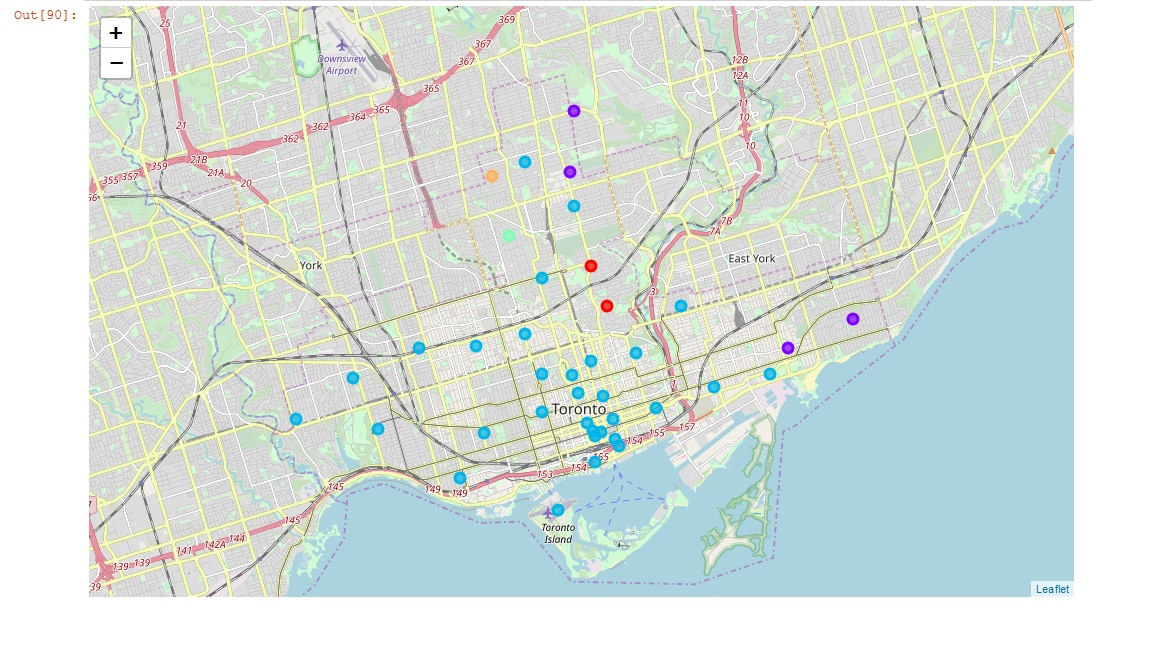

<h4>Find characteristics of clusters

In [120]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
48,Central Toronto,0,Park,Playground,Tennis Court,Restaurant,Dance Studio,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run
50,Downtown Toronto,0,Park,Playground,Trail,Dance Studio,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run


In [121]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,East Toronto,1,Health Food Store,Pub,Neighborhood,Trail,Discount Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Yoga Studio
42,East Toronto,1,Park,Sushi Restaurant,Pet Store,Movie Theater,Pub,Burrito Place,Burger Joint,Liquor Store,Brewery,Sandwich Place
44,Central Toronto,1,Lake,Swim School,Bus Line,Park,General Travel,Deli / Bodega,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant
45,Central Toronto,1,Park,Department Store,Gym,Breakfast Spot,Sandwich Place,Food & Drink Shop,Hotel,Eastern European Restaurant,Dumpling Restaurant,Donut Shop


In [122]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
41,East Toronto,2,Greek Restaurant,Coffee Shop,Italian Restaurant,Restaurant,Ice Cream Shop,Furniture / Home Store,Frozen Yogurt Shop,Pub,Pizza Place,Liquor Store
43,East Toronto,2,Café,Coffee Shop,Gastropub,Bakery,Brewery,Italian Restaurant,American Restaurant,Yoga Studio,Comfort Food Restaurant,Sandwich Place
46,Central Toronto,2,Clothing Store,Coffee Shop,Yoga Studio,Gym / Fitness Center,Salon / Barbershop,Restaurant,Rental Car Location,Park,Mexican Restaurant,Metro Station
47,Central Toronto,2,Sandwich Place,Dessert Shop,Pizza Place,Sushi Restaurant,Coffee Shop,Italian Restaurant,Gym,Café,Diner,Seafood Restaurant
49,Central Toronto,2,Coffee Shop,Pub,Pizza Place,Fried Chicken Joint,Vietnamese Restaurant,Supermarket,Light Rail Station,Sushi Restaurant,Liquor Store,American Restaurant
51,Downtown Toronto,2,Restaurant,Coffee Shop,Italian Restaurant,Pub,Café,Bakery,Pizza Place,Grocery Store,Pet Store,Sandwich Place
52,Downtown Toronto,2,Coffee Shop,Japanese Restaurant,Gay Bar,Sushi Restaurant,Restaurant,Pub,Men's Store,Mediterranean Restaurant,Hotel,Gym
53,Downtown Toronto,2,Coffee Shop,Park,Bakery,Café,Pub,Breakfast Spot,Restaurant,Mexican Restaurant,Farmers Market,Event Space
54,Downtown Toronto,2,Coffee Shop,Clothing Store,Cosmetics Shop,Japanese Restaurant,Café,Fast Food Restaurant,Ramen Restaurant,Bookstore,Pizza Place,Bakery
55,Downtown Toronto,2,Coffee Shop,Café,Restaurant,Cocktail Bar,Hotel,Cosmetics Shop,Breakfast Spot,Bakery,Beer Bar,American Restaurant


In [123]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
64,Central Toronto,3,Jewelry Store,Trail,Sushi Restaurant,Bus Line,Yoga Studio,Dessert Shop,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant


In [124]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
63,Central Toronto,4,Health & Beauty Service,Pool,Garden,Yoga Studio,Deli / Bodega,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant
